In [1]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd
import os

In [2]:
!pip install tf-nightly
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'



     |████████████████████████████████| 392.2MB 57kB/s  eta 0:00:0111MB 13.6MB/s eta 0:00:27.1MB 86.3MB/s eta 0:00:04     |██████▌                         | 80.2MB 95.9MB/s eta 0:00:04    |████████████████                | 197.2MB 115.3MB/s eta 0:00:02  | 208.2MB 115.3MB/s eta 0:00:02��███████▉              | 219.1MB 115.3MB/s eta 0:00:02   | 241.3MB 115.3MB/s eta 0:00:02�████████▎           | 248.4MB 115.3MB/s eta 0:00:02��████████████████████▏          | 258.9MB 115.3MB/s eta 0:00:02     |██████████████████████▌         | 276.4MB 64.3MB/s eta 0:00:02:00:02��        | 294.2MB 64.3MB/s eta 0:00:02     |████████████████████████▌       | 300.7MB 64.3MB/s eta 0:00:02��████████████████▉       | 304.5MB 108.4MB/s eta 0:00:01 | 324.6MB 108.4MB/s eta 0:00:01��███▊    | 339.1MB 71.4MB/s eta 0:00:01     |████████████████████████████▋   | 351.1MB 71.4MB/s eta 0:00:01��██████████████████████████  | 368.1MB 71.4MB/s eta 0:00:01
     |████████████████████████████████| 133kB 39.1MB/s eta 0:00:01
   

In [6]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = None)

#pre_trained_model.load_weights('/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

#for layer in pre_trained_model.layers:layer.trainable = False
# Expected Output is extremely large, but should end with:

#Total params: 21,802,784
#Trainable params: 0
#Non-trainable params: 21,802,784

In [7]:

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Expected Output:
# ('last layer output shape: ', (None, 7, 7, 768))

last layer output shape:  (None, 7, 7, 768)


In [8]:

# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

      

In [9]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()

# Expected output will be large. Last few lines should be:

# mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_248[0][0]             
#                                                                  activation_251[0][0]             
#                                                                  activation_256[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# flatten_4 (Flatten)             (None, 37632)        0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# dense_8 (Dense)                 (None, 1024)         38536192    flatten_4[0][0]                  
# __________________________________________________________________________________________________
# dropout_4 (Dropout)             (None, 1024)         0           dense_8[0][0]                    
# __________________________________________________________________________________________________
# dense_9 (Dense)                 (None, 1)            1025        dropout_4[0][0]                  
# ==================================================================================================
# Total params: 47,512,481
# Trainable params: 38,537,217
# Non-trainable params: 8,975,264


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

In [10]:
# Get the Horse or Human dataset
path_horse_or_human = f"{getcwd()}/../tmp2/horse-or-human.zip"
# Get the Horse or Human Validation dataset
path_validation_horse_or_human = f"{getcwd()}/../tmp2/validation-horse-or-human.zip"
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import shutil

shutil.rmtree('/tmp')
local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [11]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses') 
train_humans_dir = os.path.join(train_dir, 'humans') 
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

# Expected Output:
# 500
# 527
# 128
# 128

500
527
128
128


In [12]:

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [14]:

# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)

history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 25,
            epochs = 15,
            validation_steps = 25,
            verbose = 2)

Epoch 1/15
25/25 - 33s - loss: 6.9678 - accuracy: 0.5240 - val_loss: 2.2977 - val_accuracy: 0.5080
Epoch 2/15
25/25 - 26s - loss: 7.7893 - accuracy: 0.4920 - val_loss: 4.4343 - val_accuracy: 0.5080
Epoch 3/15
25/25 - 26s - loss: 7.5440 - accuracy: 0.5080 - val_loss: 6.3899 - val_accuracy: 0.5080
Epoch 4/15
25/25 - 24s - loss: 7.5619 - accuracy: 0.5061 - val_loss: 7.5440 - val_accuracy: 0.5080
Epoch 5/15
25/25 - 29s - loss: 6.3173 - accuracy: 0.5880 - val_loss: 7.5440 - val_accuracy: 0.5080
Epoch 6/15
25/25 - 29s - loss: 7.6053 - accuracy: 0.5040 - val_loss: 7.5440 - val_accuracy: 0.5080
Epoch 7/15
25/25 - 29s - loss: 7.8687 - accuracy: 0.4858 - val_loss: 7.5440 - val_accuracy: 0.5080
Epoch 8/15
25/25 - 26s - loss: 7.4213 - accuracy: 0.5160 - val_loss: 7.5440 - val_accuracy: 0.5080
Epoch 9/15
25/25 - 28s - loss: 8.1573 - accuracy: 0.4680 - val_loss: 7.5440 - val_accuracy: 0.5080
Epoch 10/15
25/25 - 26s - loss: 7.7893 - accuracy: 0.4920 - val_loss: 7.5440 - val_accuracy: 0.5080
Epoch 11/

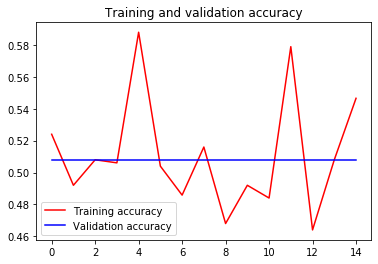

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# Submission Instructions

In [ ]:
# Now click the 'Submit Assignment' button above.

# When you're done or would like to take a break, please run the two cells below to save your work and close the Notebook. This will free up resources for your fellow learners. 

In [ ]:
%%javascript
<!-- Save the notebook -->
IPython.notebook.save_checkpoint();

In [ ]:
%%javascript
IPython.notebook.session.delete();
window.onbeforeunload = null
setTimeout(function() { window.close(); }, 1000);